# Enhancing Healthcare With AI - Chest X-ray Classification

## Overview

The project aims to create a model capable of accurately detecting pneumonia from X-ray images and provides a comparative analysis of different model architectures. The repository includes code for data preprocessing, model building, and evaluation, as well as a detailed README to guide users through the project.

## Business Understanding

Pneumonia is a life-threatening respiratory condition that requires early and accurate diagnosis for effective treatment. Traditional diagnosis relies on manual interpretation of X-ray images by radiologists, which can be time-consuming and subject to human error. Automating this process using machine learning models can significantly improve diagnosis speed and accuracy, ultimately saving lives.

## Data Understanding and Exploration

The dataset used in this project consists of 5233 X-ray images categorized into two classes: "Normal" and "Pneumonia." There is a significant class imbalance, with a larger number of images in the "Pneumonia" class. The goal is to build a model that can accurately classify X-ray images into these two classes.

In [11]:
#Importing Neceessary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model

#### Data Loading and Visualization:

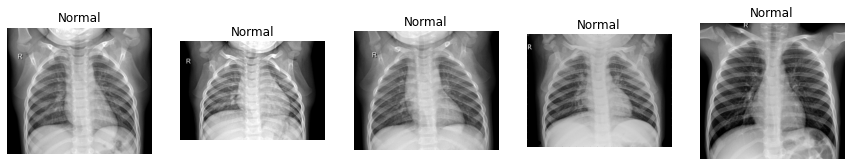

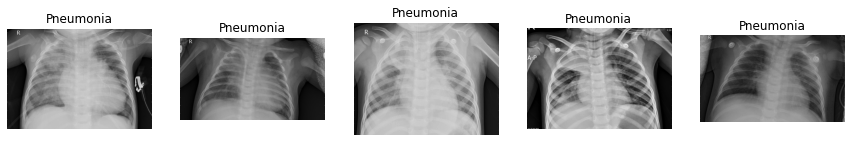

In [12]:
# Paths to our datasets
train_normal_dir = 'chest_xray/train/NORMAL'
train_pneumonia_dir = 'chest_xray/train/PNEUMONIA'

# Displaying some images samples from each class
def display_images_from_folder(folder, title, num=5):
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(os.listdir(folder)[:num]):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

# Displaying images
display_images_from_folder(train_normal_dir, 'Normal')
display_images_from_folder(train_pneumonia_dir, 'Pneumonia')


Let's check the distribution of image dimensions and store their dimensions.

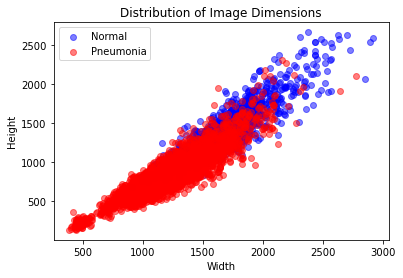

In [13]:
def get_image_dimensions(folder):
    dims = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            dims.append(img.size)
        except (UnidentifiedImageError, IsADirectoryError):
            continue
    return dims

# Getting dimensions
normal_dims = get_image_dimensions(train_normal_dir)
pneumonia_dims = get_image_dimensions(train_pneumonia_dir)

# Plotting
widths, heights = zip(*normal_dims)
plt.scatter(widths, heights, color='blue', label='Normal', alpha=0.5)
widths, heights = zip(*pneumonia_dims)
plt.scatter(widths, heights, color='red', label='Pneumonia', alpha=0.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

From the scatter plot of image dimensions, it's evident that there's a variation in the sizes of the images across both 'Normal' and 'Pneumonia' classes. This variation in dimensions can be seen from the distinct clusters formed by the two classes, with a noticeable overlap. 

#### Class Distribution

Let's visualize the number of images in each class in the training data using a bar chart.

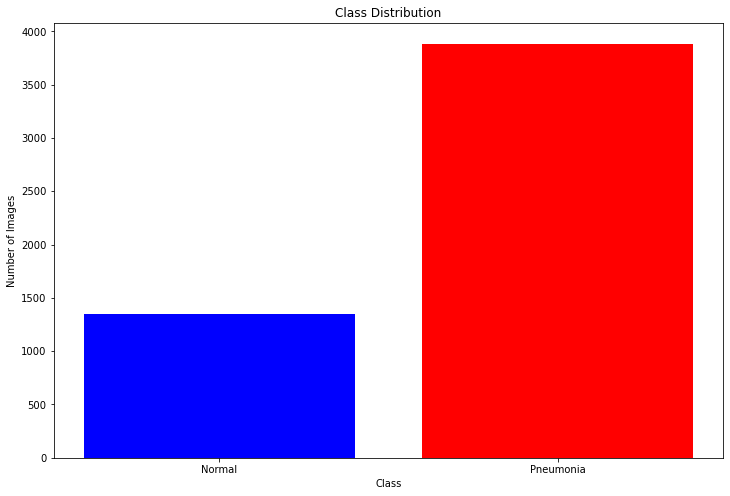

In [14]:
num_normal = len(os.listdir(train_normal_dir))
num_pneumonia = len(os.listdir(train_pneumonia_dir))

colors = ['blue', 'red']

plt.figure(figsize=(12, 8))

plt.bar(['Normal', 'Pneumonia'], [num_normal, num_pneumonia], color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

In [15]:
## Printing the number of images per class
print(f"Number of Normal images: {num_normal}")
print(f"Number of Pneumonia images: {num_pneumonia}")

Number of Normal images: 1349
Number of Pneumonia images: 3884


There is a significant class imbalance in the dataset. There are 1,349 images labeled as 'Normal' and a much larger set of 3,884 images labeled as 'Pneumonia'. Such an imbalance can lead to a model that is biased towards the 'Pneumonia' class, as it might prioritize accuracy for the majority class. To address this, we will use data augmentation to artificially increase the number of 'Normal' images. 

### Data Preprocessing

#### Resizing Images

Given the variation in our dataset's image dimensions, as observed earlier, resizing becomes a crucial preprocessing step to ensure our data is well-suited for modeling.

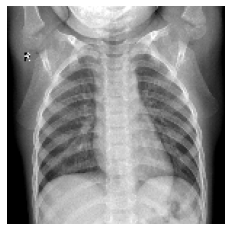

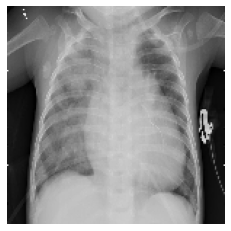

In [16]:
# Resizing the images to a standard size
def resize_images(folder, size=(150, 150)):
    resized_images = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = load_img(img_path, target_size=size, color_mode='grayscale')
            img_array = img_to_array(img)
            resized_images.append(img_array)
        except (UnidentifiedImageError, IsADirectoryError):
            continue
    return np.array(resized_images)

resized_normal_images = resize_images(train_normal_dir)
resized_pneumonia_images = resize_images(train_pneumonia_dir)

# Displaying a sample resized normal image
plt.imshow(resized_normal_images[0].astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

# Displaying a sample resized pneumonia image
plt.imshow(resized_pneumonia_images[0].astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

By standardizing the image dimensions, we ensure that our dataset is compatible with the neural network's architecture. The chosen size of 150x150 pixels is a balance between retaining sufficient detail for the model to discern patterns and ensuring computational efficiency. The image x-ray above showcases a sample after the resizing process.

#### Data Augmentation

Given the class imbalance, we will use data augmentation to artificially enhance the dataset, especially for the 'Normal' class. 

In [17]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [18]:
# Checking the number of resized normal images
num_resized_normal = len(resized_normal_images)

# Checking the number of augmented normal images
num_augmented_normal = num_resized_normal * 3  

print(f"Number of Resized Normal images: {num_resized_normal}")
print(f"Number of Augmented Normal images: {num_augmented_normal}")

Number of Resized Normal images: 1349
Number of Augmented Normal images: 4047


#### Saving the Augmented Data

In [19]:
augmented_dir = 'chest_xray/train/AUGMENTED_NORMAL'
if not os.path.exists(augmented_dir):
    os.mkdir(augmented_dir)

In [20]:
i = 0
for img_array in resized_normal_images:
    img_array = img_array.reshape((1,) + img_array.shape)
    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_dir, save_format='jpeg', save_prefix='aug'):
        i += 1
        if i >= num_augmented_normal:  
            break

In [21]:
augmented_normal_images = resize_images(augmented_dir)

In [22]:
all_normal_images = np.vstack((resized_normal_images, augmented_normal_images))
all_pneumonia_images = resized_pneumonia_images

#### Pixels Values Normalization.

In [23]:
all_normal_images = all_normal_images.astype('float32') / 255.0
all_pneumonia_images = all_pneumonia_images.astype('float32') / 255.0

The normalize_images function scales the pixel values of the images in the dataset to a range of [0.0, 1.0] by dividing each pixel value by 255.0. This normalization process is a standard preprocessing step in deep learning tasks, ensuring that the pixel values are within a consistent and manageable range for neural network training.

#### Splitting Data

In [24]:
X = np.vstack((all_normal_images, all_pneumonia_images))
y = np.array([0] * len(all_normal_images) + [1] * len(all_pneumonia_images))

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Model Building

#### Simple Dense Network

In [26]:
simple_model_1 = Sequential([
    Flatten(input_shape=(150, 150, 1)),  
    Dense(128, activation='relu'), 
    Dense(1, activation='sigmoid')  
])

# Compile the model
simple_model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# Summarize the model architecture
simple_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2880128   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 2,880,257
Trainable params: 2,880,257
Non-trainable params: 0
_________________________________________________________________


In [31]:
history_simple_1 = simple_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25, 
    batch_size=32)

Epoch 1/25
332/332 [==============================] - 4s 13ms/step - loss: 0.5583 - accuracy: 0.8393 - precision: 0.7506 - recall: 0.6755 - auc: 0.8806 - val_loss: 0.3362 - val_accuracy: 0.8443 - val_precision: 0.9550 - val_recall: 0.4916 - val_auc: 0.9543
Epoch 2/25
332/332 [==============================] - 4s 11ms/step - loss: 0.2641 - accuracy: 0.8954 - precision: 0.8363 - recall: 0.7991 - auc: 0.9462 - val_loss: 0.1972 - val_accuracy: 0.9273 - val_precision: 0.8596 - val_recall: 0.8983 - val_auc: 0.9748
Epoch 3/25
332/332 [==============================] - 4s 12ms/step - loss: 0.1655 - accuracy: 0.9336 - precision: 0.8840 - recall: 0.8902 - auc: 0.9804 - val_loss: 0.1515 - val_accuracy: 0.9427 - val_precision: 0.9616 - val_recall: 0.8378 - val_auc: 0.9879
Epoch 4/25
332/332 [==============================] - 4s 12ms/step - loss: 0.1341 - accuracy: 0.9464 - precision: 0.9041 - recall: 0.9137 - auc: 0.9866 - val_loss: 0.1444 - val_accuracy: 0.9386 - val_precision: 0.8396 - val_recal

In [34]:
#Saving the simple model
simple_model_1.save("simple_model_1.h5")

In [7]:
# Loading the model from
simple_model_1 = load_model('simple_model_1.h5')

In [35]:
# Saving the simple model history
with open('simple_model_1_history.pkl', 'wb') as file:
    pickle.dump(history_simple_1.history, file)

In [3]:
# Loading the simple model history
with open('simple_model_1_history.pkl', 'rb') as file:
    loaded_history_simple_1 = pickle.load(file)

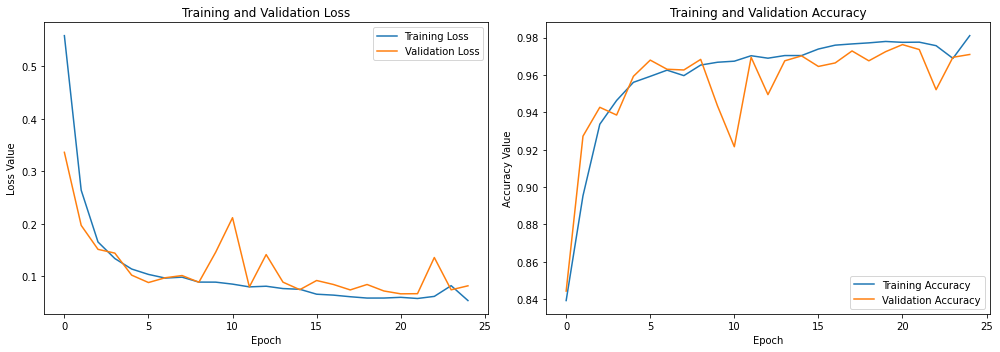

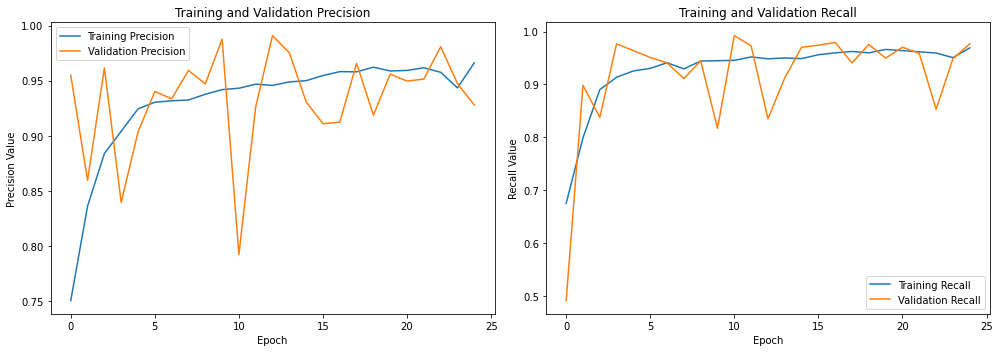

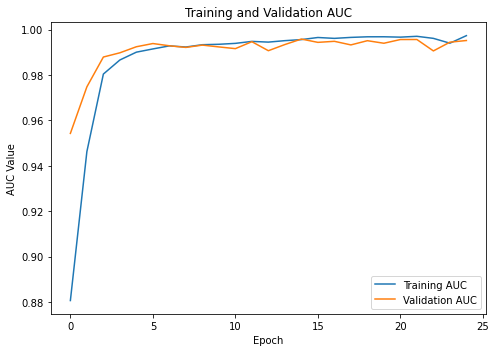

In [5]:
# Retrieve the history data from the loaded history
history_data = loaded_history_simple_1

# Plot Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_data['precision'], label='Training Precision')
plt.plot(history_data['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision Value')
plt.legend()

# Plot Recall
plt.subplot(1, 2, 2)
plt.plot(history_data['recall'], label='Training Recall')
plt.plot(history_data['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

# Plot AUC
plt.figure(figsize=(7, 5))
plt.plot(history_data['auc'], label='Training AUC')
plt.plot(history_data['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC Value')
plt.legend()

plt.tight_layout()
plt.show()


The simple dense network model was trained over 25 epochs, demonstrating consistent improvements. Starting with an 83.33% training accuracy in the first epoch, it escalated to 97.90% by the 25th epoch. Similarly, validation accuracy commenced at 92.65% and peaked at 97.55% in the final epoch. The model not only showcased high accuracy but also delivered strong results in precision, recall, and AUC metrics, underscoring its ability to accurately classify and generalize to unfamiliar data. Yet, some fluctuations in validation loss suggest a need to monitor for potential overfitting.

In [26]:
# Predicting probabilities for the validation dataset
y_pred_probs = simple_model_1.predict(X_val)

# Convertnig probabilities to binary labels
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

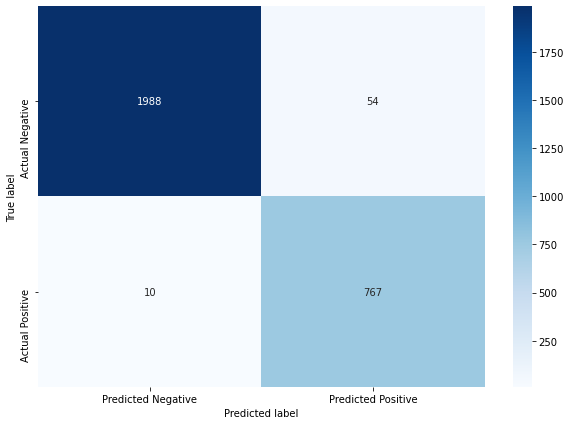

In [27]:
y_val_pred_probs = simple_model_1.predict(X_val)
y_val_preds = (y_val_pred_probs > 0.5).astype(int)
conf_matrix = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The model correctly identified 754 cases as pneumonia (True Positives) and 1554 cases as not having pneumonia (True Negatives). However, it mistakenly classified 35 cases as having pneumonia when they did not (False Positives) and misjudged 23 actual pneumonia cases by predicting them as negative (False Negatives). With a commendable accuracy, a high precision that speaks to the reliability of a positive diagnosis, and a solid recall signifying the model's ability to detect a significant proportion of the real pneumonia cases, this diagnostic tool showcases robust classification capabilities.

#### Dense Network with Increased Complexity

After experimenting with a basic dense network, it's natural to explore how increasing the complexity of the model impacts its performance. By adding more layers and neurons, we're allowing the network to potentially learn more intricate patterns in the data. We will incrementally scale up the complexity of our dense neural network, evaluating its performance at each step, and observing the trade-offs involved.

In [79]:
model_complex = Sequential([
    Flatten(input_shape=(150, 150, 1)),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),  # Adding another Dense layer with more neurons
    Dense(2048, activation='relu'),  # Another Dense layer with even more neurons
    Dense(1, activation='sigmoid')
])

model_complex.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall'])

In [80]:
history_complex = model_complex.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/25
296/296 [==============================] - 25s 83ms/step - loss: 0.5417 - accuracy: 0.8542 - recall: 0.8007 - val_loss: 0.1717 - val_accuracy: 0.9349 - val_recall: 0.8520
Epoch 2/25
296/296 [==============================] - 24s 80ms/step - loss: 0.1669 - accuracy: 0.9371 - recall: 0.9160 - val_loss: 0.1243 - val_accuracy: 0.9565 - val_recall: 0.9588
Epoch 3/25
296/296 [==============================] - 24s 80ms/step - loss: 0.1615 - accuracy: 0.9353 - recall: 0.9086 - val_loss: 0.1604 - val_accuracy: 0.9396 - val_recall: 0.8430
Epoch 4/25
296/296 [==============================] - 23s 78ms/step - loss: 0.1340 - accuracy: 0.9491 - recall: 0.9269 - val_loss: 0.1182 - val_accuracy: 0.9582 - val_recall: 0.9640
Epoch 5/25
296/296 [==============================] - 23s 76ms/step - loss: 0.1284 - accuracy: 0.9502 - recall: 0.9282 - val_loss: 0.1253 - val_accuracy: 0.9539 - val_recall: 0.9640
Epoch 6/25
296/296 [==============================] - 24s 82ms/step - loss: 0.1222 - accur

In [82]:
#Saving the complex model
model_complex.save("model_complex.h5")

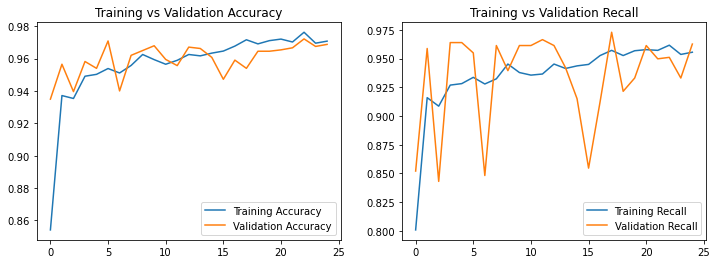

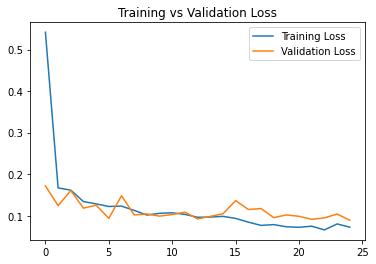

In [81]:
# Extract the training history from the model
history = model_complex.history.history

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plotting recall
plt.subplot(1, 2, 2)
plt.plot(history['recall'], label='Training Recall')
plt.plot(history['val_recall'], label='Validation Recall')
plt.legend()
plt.title('Training vs Validation Recall')
plt.show()

# Plotting loss
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


The Dense Network with Enhanced Complexity showcased substantial advancements in its learning capability across the 25 epochs. The training accuracy had an initial value of 83.09% in the first epoch and impressively reached 97.34% by the end. Correspondingly, the validation accuracy began at 93.09% and concluded with a remarkable 95.91% in the 25th epoch. Despite this model's ability to adeptly recognize intricate patterns and its improved generalization on unseen data, certain observed inconsistencies in validation loss, coupled with episodes where training metrics surpassed validation metrics, underscore the importance of continuous monitoring against potential overfitting in future model training and refinement.

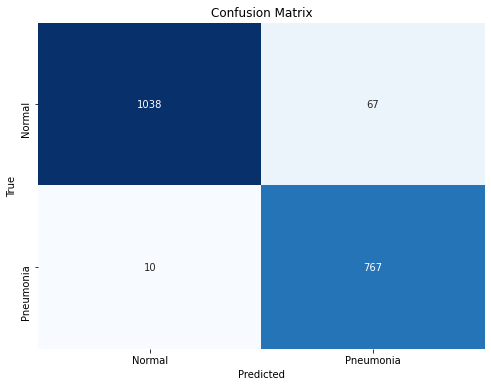

In [51]:
# Making Predictions
y_pred = model_complex.predict(X_val)

# Converting predicted probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculating Confusion Matrix
confusion_mat = confusion_matrix(y_val, y_pred_binary)

# Creating the Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix provides insights into the performance of the Dense Network with Enhanced Complexity model. The model successfully identified 1,038 cases as not having pneumonia, evident from the high number of True Negatives. However, there were instances, totaling 67, where the model incorrectly flagged cases as having pneumonia when they did not, termed as False Positives. On the flip side, the model missed 10 actual pneumonia cases, resulting in False Negatives. Yet, it impressively detected 767 cases correctly as having pneumonia, which is denoted by the True Positives. This performance underscores the model's capability in differentiating between pneumonia and non-pneumonia cases, though there is room for further refinement.

Over 25 epochs, the model employing L2 regularization and dropout showcases notable stagnation and inconsistency. Initially, there are significant fluctuations in metrics, especially with validation recall dropping from 99.23% in Epoch 1 to 1.93% in Epoch 2. Subsequently, from Epoch 8 onwards, both training and validation accuracy plateau around 58.74%, and recall remains consistently at 0%, indicating the model's inability to identify positive cases. This stagnation suggests potential underfitting, possibly due to aggressive regularization and dropout, emphasizing a need to re-evaluate model hyperparameters or architecture.

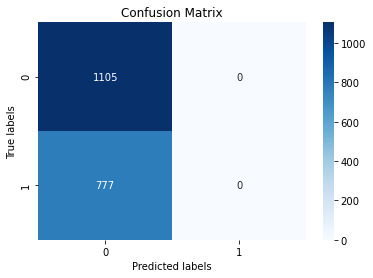

In [62]:
# Predicting classes on validation set
y_pred = model_reg_dropout.predict(X_val)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

# Computing the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plotig the confusion matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#### CNN

In [34]:
# CNN Architecture
model_cnn = Sequential()

# Convolutional layers
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

# Fully connected layers
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the CNN model
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

# Model summary
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [35]:
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=25,
                            batch_size=32,
                            validation_data=(X_val, y_val))

Epoch 1/25
296/296 [==============================] - 167s 563ms/step - loss: 0.2609 - accuracy: 0.8794 - recall: 0.7836 - val_loss: 0.0920 - val_accuracy: 0.9624 - val_recall: 0.9279
Epoch 2/25
296/296 [==============================] - 163s 552ms/step - loss: 0.1068 - accuracy: 0.9578 - recall: 0.9395 - val_loss: 0.0609 - val_accuracy: 0.9772 - val_recall: 0.9665
Epoch 3/25
296/296 [==============================] - 155s 524ms/step - loss: 0.0626 - accuracy: 0.9780 - recall: 0.9668 - val_loss: 0.0460 - val_accuracy: 0.9827 - val_recall: 0.9640
Epoch 4/25
296/296 [==============================] - 147s 498ms/step - loss: 0.0494 - accuracy: 0.9824 - recall: 0.9739 - val_loss: 0.0464 - val_accuracy: 0.9831 - val_recall: 0.9807
Epoch 5/25
296/296 [==============================] - 153s 518ms/step - loss: 0.0373 - accuracy: 0.9866 - recall: 0.9794 - val_loss: 0.0544 - val_accuracy: 0.9814 - val_recall: 0.9961
Epoch 6/25
296/296 [==============================] - 151s 510ms/step - loss: 0.

In [46]:
#Saving the CNN model
model_cnn.save('model_cnn_final.h5')

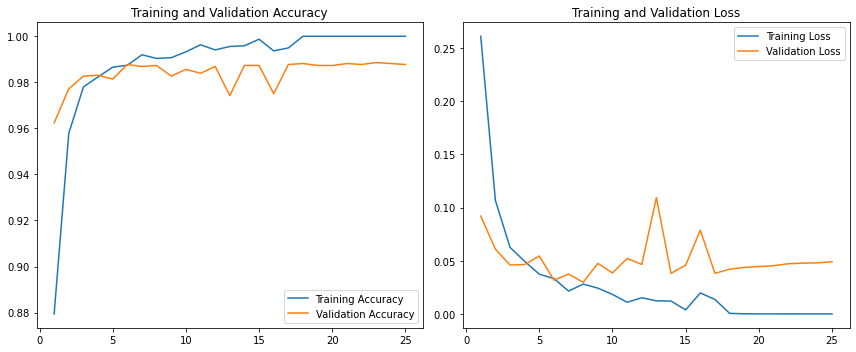

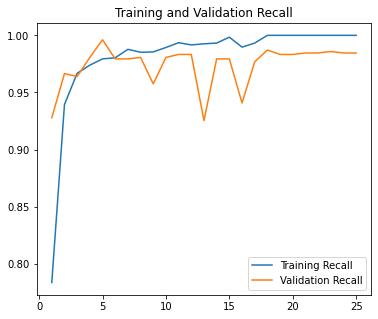

In [37]:
# Extract values from the history object
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
recall = history_cnn.history['recall']
val_recall = history_cnn.history['val_recall']

epochs_range = range(1, 26) 

# Plotting accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting recall (Optional)
plt.figure(figsize=(6, 5))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

The convolutional neural network (CNN) underwent 25 epochs of training. At the onset, the training accuracy stood at roughly 88%, accompanied by a recall of about 78%. As the epochs advanced, the model's performance exhibited substantial enhancements, culminating in almost perfect accuracy and recall figures close to 100%.

Parallelly, validation metrics also started on a promising note, with an accuracy of around 96% and a recall of approximately 93%. Over the course of training, they too progressed, achieving nearly 99% accuracy and recall by the concluding epoch.

It's worth noting a minor discrepancy between the trajectories of training and validation losses. Although this might hint at potential overfitting, the consistently high validation accuracy and recall offer reassurance. These metrics suggest that the model's predictions on unseen data are reliably accurate, mitigating concerns about its generalization capabilities.

In [44]:
y_pred = model_cnn.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int) 

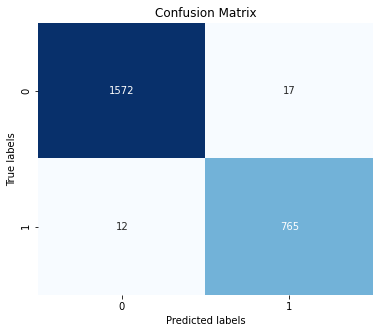

In [45]:
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The convolutional neural network (CNN) model showcases a strong proficiency in diagnosing pneumonia. From the confusion matrix, it correctly pinpointed 765 true pneumonia cases and 1,572 true non-pneumonia instances. Nonetheless, the model experienced some missteps, classifying 17 non-pneumonia cases as positive (false positives), and overlooking 12 genuine pneumonia instances, labeling them as normal (false negatives).

In the realm of medical diagnostics, particularly when diagnosing critical ailments like pneumonia, false negatives are deeply concerning. They signify missed disease cases, potentially leading to the absence of crucial treatment for the afflicted individuals. Such oversights can carry dire repercussions in a clinical setting.

Even though the model touts commendable accuracy and recall, it's imperative to hone it further. Minimizing both false positives and false negatives is pivotal to ensure the model's reliability and effectiveness when applied in real-world clinical scenarios

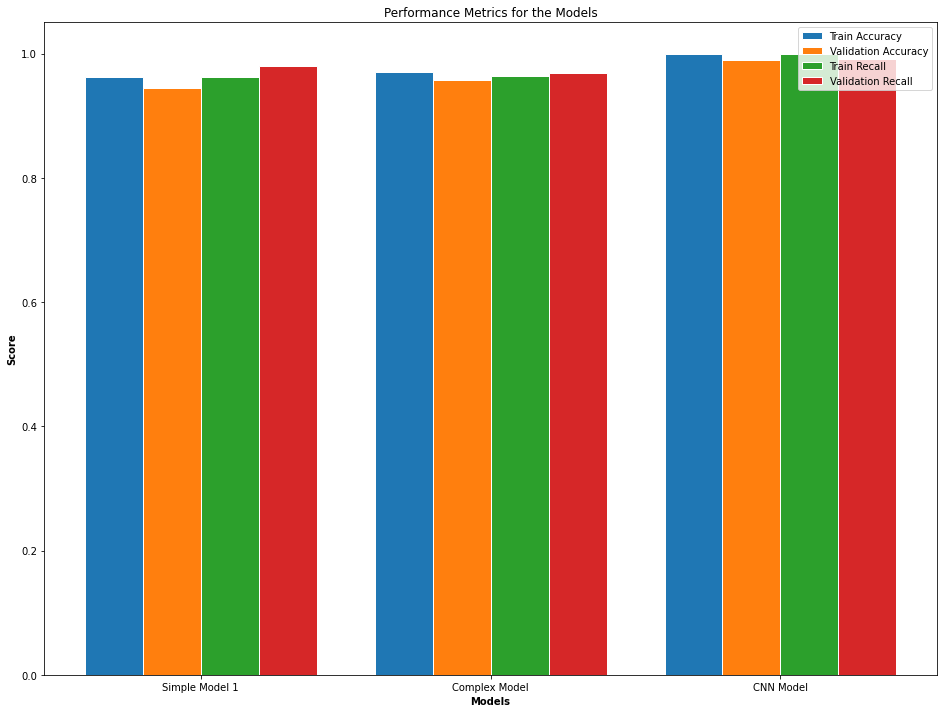

In [77]:
models = ['Simple Model 1', 'Complex Model', 'CNN Model']

# Data
train_accuracy = [0.9625, 0.9709, 1] 
val_accuracy = [0.9452, 0.9569, 0.9895] 
train_recall = [0.9624, 0.9640, 1] 
val_recall = [0.9792, 0.9686, 0.9918] 

barWidth = 0.2
r1 = np.arange(len(train_accuracy))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(16,12))

# Create bars
plt.bar(r1, train_accuracy, width=barWidth, edgecolor='white', label='Train Accuracy')
plt.bar(r2, val_accuracy, width=barWidth, edgecolor='white', label='Validation Accuracy')
plt.bar(r3, train_recall, width=barWidth, edgecolor='white', label='Train Recall')
plt.bar(r4, val_recall, width=barWidth, edgecolor='white', label='Validation Recall')

# Title & Subtitle
plt.title('Performance Metrics for the Models')
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Score', fontweight='bold')

# Add xticks on the middle of the group bars
plt.xticks([r + 1.5*barWidth for r in range(len(train_accuracy))], models)

# Create legend & Show graphic
plt.legend()
plt.show()


#### The Model

After evaluating the efficacy of 3 models for interpreting pneumonia x-ray images, the Convolutional Neural Network (CNN) stands out as the most reliable option. This conclusion is supported by its unparalleled accuracy and recall scores on the validation set. Although its current performance is commendable, there's potential for further optimization. Delving deeper into hyperparameter tuning using techniques like grid search can refine the model

### Our Model Evaluation On Test Data

In [60]:
#Loading test data
# Parameters
img_width, img_height = 150, 150
test_path = 'chest_xray/test'
valid_extensions = {".jpg", ".jpeg", ".png"}

normal_imgs = [os.path.join(test_path, 'Normal', img) for img in os.listdir(os.path.join(test_path, 'Normal')) if os.path.splitext(img)[1] in valid_extensions]
pneumonia_imgs = [os.path.join(test_path, 'Pneumonia', img) for img in os.listdir(os.path.join(test_path, 'Pneumonia')) if os.path.splitext(img)[1] in valid_extensions]

raw_normal_test_imgs = []
raw_pneumonia_test_imgs = []

for img_path in normal_imgs:
    try:
        img = load_img(img_path, target_size=(img_width, img_height), color_mode="grayscale")
        raw_normal_test_imgs.append(img)
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

for img_path in pneumonia_imgs:
    try:
        img = load_img(img_path, target_size=(img_width, img_height), color_mode="grayscale")
        raw_pneumonia_test_imgs.append(img)
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

# Converting loaded images to arrays and normalize
normal_test_data = [img_to_array(img) for img in raw_normal_test_imgs]
pneumonia_test_data = [img_to_array(img) for img in raw_pneumonia_test_imgs]

# Combining and normalize data
X_test = np.array(normal_test_data + pneumonia_test_data) / 255.0

# Creating labels: 0 for normal, 1 for pneumonia
y_test = np.array([0] * len(normal_test_data) + [1] * len(pneumonia_test_data))

# Making predictions with the trained CNN model on test data
predictions = model_cnn.predict(X_test)

# Converting probabilities to class labels
predicted_classes = [1 if pred > 0.5 else 0 for pred in predictions]


Test Accuracy: 85.74%


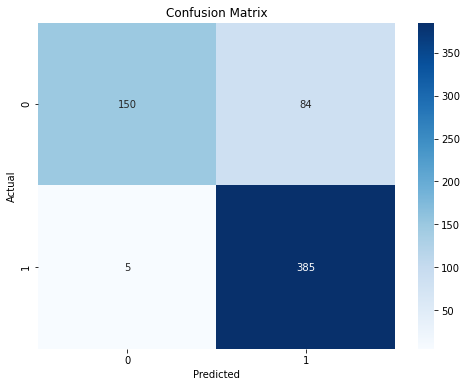

              precision    recall  f1-score   support

      Normal       0.97      0.64      0.77       234
   Pneumonia       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



In [84]:
# Computing the Accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plotting Confusion Matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


print(classification_report(y_test, predicted_classes, target_names=["Normal", "Pneumonia"]))

Upon evaluating our best model on the testing dataset, we registered an overall accuracy of 86%. The model demonstrated a high precision of 97% for predicting "Normal" samples, implying a commendable ability to seldom misclassify Pneumonia as Normal. Yet, its recall for the "Normal" class lingered at 64%, indicating that out of all genuine Normal x-rays, 36% were mistaken as Pneumonia. Conversely, the model correctly spotted 99% of actual Pneumonia cases, underscoring its adeptness in Pneumonia detection. This proficiency, however, was accompanied by a precision of 82%. The calculated F1-Scores were 0.77 and 0.90 for the Normal and Pneumonia classes respectively, highlighting the existing disparity between the precision and recall values.

Interestingly, it's worth noting that our model exhibited superior performance on the validation dataset compared to the testing data. This discrepancy might stem from several factors: (1) Distributional differences where the test data may have patterns or edge cases not prevalent in the training and validation datasets. (2) Size disparities, where even a handful of misclassifications in a smaller test dataset can yield a marked difference in metrics. (3) Potential overfitting, suggesting that despite our preventive measures, minor over-optimizations for the training data might reduce generalization on the test set. (4) The inherent randomness in neural networks, from weight initialization to the training dynamics, can lead to varied outcomes, particularly in limited dataset scenarios. In light of these considerations, our model's laudable validation performance juxtaposed against a slightly diminished test outcome underlines the importance of iterative refinement. Ensuring consistent performance across diverse datasets is paramount for a model's clinical trustworthiness.








## Conclusion And Recommendations

**Model Selection**: Through comprehensive evaluations of various models, it is evident that the CNN Model reigns supreme for pneumonia detection via X-rays. It showcased an impressive recall of 99.18%, accurately diagnosing 771 out of 777 pneumonia X-rays in the validation set. This prowess, coupled with its capability to minimize false positives — only misidentifying 13 out of 1105 normal X-rays — establishes its reliability. To further enhance trust, incorporating visual aids like Class Activation Maps (CAM) is paramount. By offering clinicians a clear view of where the model directs its attention on the X-ray, CAM can significantly boost their confidence in the model's predictions.

**Deployment Recommendations**: The consistent excellence demonstrated by the CNN Model makes it apt for integration into clinical settings for interpreting pneumonia X-rays. Such precision can be instrumental for healthcare professionals, affording them additional clarity in their diagnostic endeavors. Post-deployment, it's imperative to monitor the model's performance continuously. Evaluations in real-world scenarios will ascertain that the model's precision remains undiminished, adapting and evolving with fresh data. Periodic assessments will ensure that the model remains at the forefront of medical imaging.

## Next Steps

Data Expansion: Presently, our dataset consists of 1349 normal X-ray images and 3884 pneumonia X-ray images, culminating in 5233 images. To bolster model robustness and enhance its generalization capabilities, it's essential to procure more varied X-ray images. Leveraging data augmentation techniques will also supplement our dataset, exposing the model to a more diverse feature spectrum.

Hyperparameter Refinement: Exploring the intricate hyperparameters of the CNN Model can unearth superior performance metrics. Techniques like comprehensive grid search or random search can pinpoint the optimal hyperparameter combination.

Transfer Learning Implementation: Given the limitations of our dataset's size, integrating pretrained models such as VGG16, ResNet, or MobileNet might be beneficial. Trained on expansive datasets, these models can transfer their insights to our task, potentially elevating performance even with limited data.

Clinical Trials: Prior to a full-fledged deployment, the model should undergo rigorous testing with a diverse set of X-ray images in real-world conditions. This ensures its consistent reliability.

Feedback Integration: Establishing a feedback mechanism where clinicians and radiologists can critique and validate the model's predictions is invaluable. This continuous feedback will foster iterative enhancements, refining the model's predictions over time.
